In [1]:
# Install required libraries
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.4 MB/s eta 0:00:00


In [2]:
# Import required libraries
import cv2
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import time

RL Envirnoment from Part 1

In [3]:
# Definition of the Grid Environment class.

class GridEnvironment(gym.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = { 'render.modes': [] }

    # Initialization function
    def __init__(self):

      self.environment_width = 5
      self.environment_height = 5

      self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)
      self.action_space = spaces.Discrete(4)
      #self.max_timesteps = 10

      self.timestep = 0
      self.agent_pos = [4, 0]
      self.goal_pos = [1, 3]
      self.battery_pos = [1, 0]
      self.super_battery_pos = [1, 2]
      self.rock1_pos = [4, 2]
      self.rock2_pos = [3, 3]
      self.battery_quantity = 1
      self.super_battery_quantity = 1
      self.rock1_quantity = 1
      self.rock2_quantity = 1
      self.state = np.zeros((5,5))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.battery_pos)] = 2
      self.state[tuple(self.super_battery_pos)] = 3
      self.state[tuple(self.rock1_pos)] = 4
      self.state[tuple(self.rock2_pos)] = 4
      self.state[tuple(self.goal_pos)] = 5

    # Reset function
    def reset(self, **kwargs):
      self.agent_pos = [4, 0]
      self.goal_pos = [1, 3]
      self.battery_pos = [1, 0]
      self.super_battery_pos = [1, 2]
      self.rock1_pos = [4, 2]
      self.rock2_pos = [3, 3]
      self.battery_quantity = 1
      self.super_battery_quantity = 1
      self.rock1_quantity = 1
      self.rock2_quantity = 1
      self.state = np.zeros((5,5))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.battery_pos)] = 2
      self.state[tuple(self.super_battery_pos)] = 3
      self.state[tuple(self.rock1_pos)] = 4
      self.state[tuple(self.rock2_pos)] = 4
      self.state[tuple(self.goal_pos)] = 5
      observation = self.state.flatten()

      info = {}

      return observation, info

    # Step function: Contains the implementation for what happens when an
    # agent takes a step in the environment.
    def step(self, action):

      if action == 0: #down
        self.agent_pos[0] += 1
      if action == 1: #up
        self.agent_pos[0] -= 1
      if action == 2: #right
        self.agent_pos[1] += 1
      if action == 3: #left
        self.agent_pos[1] -= 1

      # Comment this to demonstrate the truncation condition.
      #self.agent_pos = np.clip(self.agent_pos, 0, 4)

      reward = 0

      # Condition to check if agent is traversing to a cell beyond the permitted cells
      # This helps the agent to learn how to behave in a safe and predictable manner
      truncated = False if np.all((np.asarray(self.agent_pos) >= 0 ) & (np.asarray(self.agent_pos) <= 4)) else True

      if truncated:
        self.agent_pos = np.clip(self.agent_pos, 0, 4)
        reward -= 100

      self.state = np.zeros((5,5))
      self.state[tuple(self.agent_pos)] = 1
      if (self.battery_quantity > 0):
        if np.array_equal(self.agent_pos, self.battery_pos):
          self.state[tuple(self.battery_pos)] = 1
        else:
          self.state[tuple(self.battery_pos)] = 2
      if (self.super_battery_quantity > 0) :
        if np.array_equal(self.agent_pos, self.super_battery_pos):
          self.state[tuple(self.super_battery_pos)] = 1
        else:
          self.state[tuple(self.super_battery_pos)] = 3
      if (self.rock1_quantity > 0) :
        if np.array_equal(self.agent_pos, self.rock1_pos):
          self.state[tuple(self.rock1_pos)] = 1
        else:
          self.state[tuple(self.rock1_pos)] = 4
      if (self.rock2_quantity > 0) :
        if np.array_equal(self.agent_pos, self.rock2_pos):
          self.state[tuple(self.rock2_pos)] = 1
        else:
          self.state[tuple(self.rock2_pos)] = 4
      if np.array_equal(self.agent_pos, self.goal_pos):
        self.state[tuple(self.goal_pos)] = 1
      else:
        self.state[tuple(self.goal_pos)] = 5
      observation = self.state.flatten()

      if np.array_equal(self.agent_pos, self.goal_pos):
        reward += 100
      if np.array_equal(self.agent_pos, self.battery_pos) and (self.battery_quantity > 0):
        reward += 3
        self.battery_quantity -= 1
      if np.array_equal(self.agent_pos, self.super_battery_pos) and (self.super_battery_quantity > 0):
        reward += 5
        self.super_battery_quantity -= 1
      if np.array_equal(self.agent_pos, self.rock1_pos) and (self.rock1_quantity > 0):
        reward -= 5
        self.rock1_quantity -= 1
      if np.array_equal(self.agent_pos, self.rock2_pos) and (self.rock2_quantity > 0):
        reward -= 5
        self.rock2_quantity -= 1

      #self.timestep += 1

      # Condition to check for termination (episode is over)
      terminated = True if (np.array_equal(self.agent_pos, self.goal_pos)) else False

      info = {}

      return observation, reward, terminated, truncated, info

    # Render function: Visualizes the environment
    def render(self, plot=False):
      plt.title('Grid Environment')
      plt.imshow(self.state)

# PART 2: SARSA Algorithm

In [4]:
#Step 1) and 2) a.

env = GridEnvironment()

#intial Q-table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

print("Intial Q-table")
print(Q_table)

#epsilon decay values
epsilon_value_initial = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.005

learning_rate = 0.1  #alpha
episodes = 1000
gamma = 0.8

total_step = 0

#iniitalize the arrays to store the values and plot graph
initial_rewards = []
epsilon_values = []

for episode in range(episodes):

  #starting S
  obs, info = env.reset()
  step = 0
  total_rewards = 0

  # obs = obs.astype(int) #old code
  # print(obs)

  # getting the correct state index of the agent to update the Q-table
  state_number = np.where(obs == 1)[0][0]

  # print("Intial State Number is:",state_number)
  # print(type(state_number))

  #choose A from S, using the epsilon greedy policy
  if np.random.uniform(0,1) < epsilon_value_initial:
    action = np.random.choice(env.action_space.n)
  else:
    action = np.argmax(Q_table[state_number])

  # print("Action is:",action)

  terminated, truncated = False, False

  while not terminated:

    total_step += 1

    #collect the next S
    next_obs, reward, terminated, truncated, info = env.step(action)

    #convert to int values for finding argmax
    # next_obs = next_obs.astype(int)

    next_state_number = np.where(next_obs == 1)[0][0]   #next state index for Q-table

    # choose A' from S'(based on new_obs) then that along with intial action will be used to calculate the sarsa update
    if np.random.uniform(0,1) < epsilon_value_initial:
      next_action = np.random.choice(env.action_space.n)
    else:
      next_action = np.argmax(Q_table[next_state_number])

    #update the Q_table
    Q_table[state_number,action] += learning_rate * (reward + gamma * Q_table[next_state_number,next_action] - Q_table[state_number,action])

    state_number = next_state_number   #set state to next_state value
    action = next_action
    total_rewards += reward
    step += 1

    if terminated or truncated:
      break

  initial_rewards.append(total_rewards)
  epsilon_value_initial = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  epsilon_values.append(epsilon_value_initial)

print("Total Steps:", total_step)
print("\nFinal Q-table")
print(Q_table)



Intial Q-table
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Total Steps: 6071

Final Q-table
[[ 1.00684765e+01 -2.69927643e+01  0.00000000e+00 -3.41972215e+01]
 [ 4.91279908e+01 -3.34723035e+01  2.92500591e+00 -1.36244639e+00]
 [ 6.92546962e+01 -9.36275238e+00  8.00000000e-01 -1.41031134e-01]
 [ 1.90000000e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.47863651e-01 -1.86788663e+00  4.95775928e+01 -3.94519962e+01]
 [ 3.54275295e+01  1.93156210e+01  8.44542562e+01  2.62635847e+01]
 [ 4.84430763e+01  4.05238025e+01  1.00000000e+02  5.06483466e+01]
 [ 0.00000000e+00  0.00000000e+00  0.000

Grid Envirnoment after SARSA learning for the given setup:


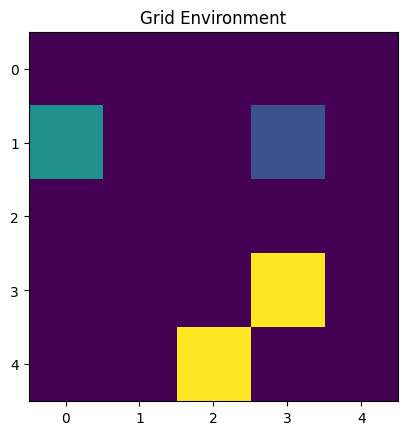

In [5]:
print("Grid Envirnoment after SARSA learning for the given setup:")
env.render()

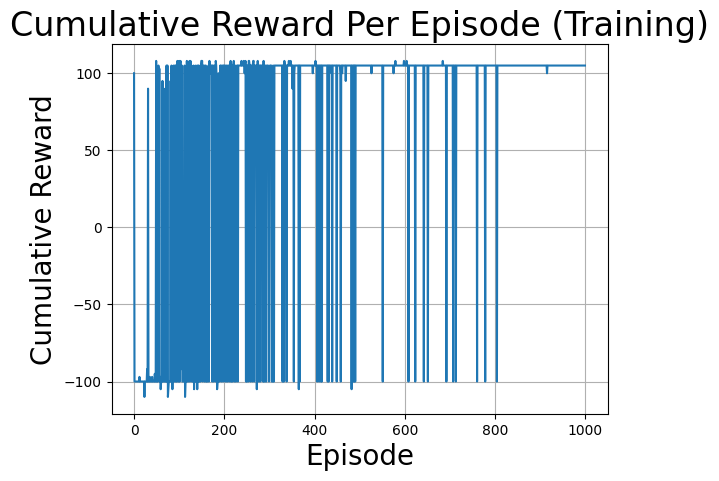

In [6]:
#Step 2) b.
plt.figure()
plt.plot(initial_rewards)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode (Training)', fontsize=24)
plt.grid()
plt.show()

[1.0, 0.9950623544007555, 0.9901493354116764, 0.985260820207032, 0.9803966865736877, 0.9755568129080493, 0.970741078213023, 0.9659493620949908, 0.9611815447608, 0.9564375070147689, 0.9517171302557069, 0.947020296473949, 0.9423468882484062, 0.9376967887436294, 0.9330698817068888, 0.9284660514652673, 0.9238851829227694, 0.9193271615574428, 0.9147918734185159, 0.9102792051235491, 0.9057890438555999, 0.9013212773604029, 0.896875793943563, 0.892452482467763, 0.888051232349986, 0.8836719335587495, 0.8793144766113556, 0.8749787525711541, 0.8706646530448178, 0.8663720701796339, 0.8621008966608072, 0.8578510257087774, 0.8536223510765493, 0.8494147670470367, 0.8452281684304199, 0.8410624505615153, 0.8369175092971592, 0.8327932410136044, 0.8286895426039287, 0.8246063114754583, 0.820543445547202, 0.8165008432473004, 0.8124784035104852, 0.8084760257755536, 0.8044936099828537, 0.8005310565717833, 0.7965882664783007, 0.7926651411324482, 0.7887615824558879, 0.7848774928594494, 0.7810127752406908, 0.77

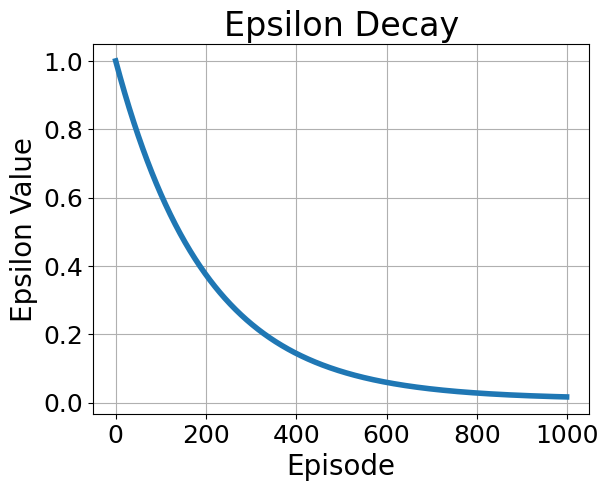

In [7]:
#Step 2) c.
# epsilon_values = [(epsilon_value ** i) * 1 for i in range(episodes)]
print(epsilon_values)

plt.figure()
plt.plot(epsilon_values, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.ylim(ymin=0, ymax=1)
# plt.xlim(xmin=0, xmax=500)
plt.grid()
plt.show()

# Hyperparameter Tunning: Changing Discount Factor & Epsilon Decay Rate

Hyperparameter Change #1_1: Change Epsilon Decay rate = 0.001 and Discount Factor = 0.85

In [8]:
env = GridEnvironment()

#intial Q-table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

#epsilon decay values
epsilon_value_initial = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.001                # Hyperparameter #1

learning_rate = 0.1  #alpha
episodes = 1000
gamma = 0.85                        # Hyperparameter #2

total_step = 0

#iniitalize the arrays to store the values and plot graph
epsilon_values_1 = []
final_rewards_1 = []

start_time = time.time()
total_rewards = 0

for episode in range(episodes):

  #starting S
  obs, info = env.reset()
  step = 0
  total_rewards = 0

  # getting the correct state index of the agent to update the Q-table
  state_number = np.where(obs == 1)[0][0]

  #choose A from S, using the epsilon greedy policy
  if np.random.uniform(0,1) < epsilon_value_initial:
    action = np.random.choice(env.action_space.n)
  else:
    action = np.argmax(Q_table[state_number])

  terminated, truncated = False, False

  while not terminated:

    total_step += 1

    #collect the next S
    next_obs, reward, terminated, truncated, info = env.step(action)


    next_state_number = np.where(next_obs == 1)[0][0]   #next state index for Q-table

    # choose A' from S'(based on new_obs) then that along with intial action will be used to calculate the sarsa update
    if np.random.uniform(0,1) < epsilon_value_initial:
      next_action = np.random.choice(env.action_space.n)
    else:
      next_action = np.argmax(Q_table[next_state_number])

    #update the Q_table
    Q_table[state_number,action] += learning_rate * (reward + gamma * Q_table[next_state_number,next_action] - Q_table[state_number,action])

    state_number = next_state_number   #set state to next_state value
    action = next_action
    total_rewards += reward
    step += 1

    if terminated or truncated:
      break

  final_rewards_1.append(total_rewards)
  epsilon_value_initial = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  epsilon_values_1.append(epsilon_value_initial)

end_time  = time.time()

training_time = end_time - start_time

# print("\nFinal Q-table")
# print(Q_table)

print("\n")
print(f"Training time for Hyperparameter #1_1: {training_time}")
print(f"Performance of training #1_1: {total_rewards/episodes}")





Training time for Hyperparameter #1_1: 1.2154552936553955
Performance of training #1_1: -0.095


Hyperparameter Change #1_2: Change Epsilon Decay rate = 0.001 and Discount Factor = 0.99

In [9]:
env = GridEnvironment()

#intial Q-table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

#epsilon decay values
epsilon_value_initial = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.001                # Hyperparameter #1

learning_rate = 0.1  #alpha
episodes = 1000
gamma = 0.99                        # Hyperparameter #2

total_step = 0

#iniitalize the arrays to store the values and plot graph
epsilon_values_2 = []
final_rewards_2 = []

start_time = time.time()
total_rewards = 0

for episode in range(episodes):

  #starting S
  obs, info = env.reset()
  step = 0
  total_rewards = 0

  # getting the correct state index of the agent to update the Q-table
  state_number = np.where(obs == 1)[0][0]

  #choose A from S, using the epsilon greedy policy
  if np.random.uniform(0,1) < epsilon_value_initial:
    action = np.random.choice(env.action_space.n)
  else:
    action = np.argmax(Q_table[state_number])

  terminated, truncated = False, False

  while not terminated:

    total_step += 1

    #collect the next S
    next_obs, reward, terminated, truncated, info = env.step(action)

    next_state_number = np.where(next_obs == 1)[0][0]   #next state index for Q-table

    # choose A' from S'(based on new_obs) then that along with intial action will be used to calculate the sarsa update
    if np.random.uniform(0,1) < epsilon_value_initial:
      next_action = np.random.choice(env.action_space.n)
    else:
      next_action = np.argmax(Q_table[next_state_number])

    #update the Q_table
    Q_table[state_number,action] += learning_rate * (reward + gamma * Q_table[next_state_number,next_action] - Q_table[state_number,action])

    state_number = next_state_number   #set state to next_state value
    action = next_action
    total_rewards += reward
    step += 1

    if terminated or truncated:
      break

  final_rewards_2.append(total_rewards)
  epsilon_value_initial = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  epsilon_values_2.append(epsilon_value_initial)

end_time  = time.time()

training_time = end_time - start_time

# print("\nFinal Q-table")
# print(Q_table)

print("\n")
print(f"Training time for Hyperparameter #1_2: {training_time}")
print(f"Performance of training #1_2: {total_rewards/episodes}")





Training time for Hyperparameter #1_2: 2.7344841957092285
Performance of training #1_2: -0.1


Hyperparameter Change #1_3: Change Epsilon Decay rate = 0.001 and Discount Factor = 0.5

In [10]:
env = GridEnvironment()

#intial Q-table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

#epsilon decay values
epsilon_value_initial = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.001                # Hyperparameter #1

learning_rate = 0.1  #alpha
episodes = 1000
gamma = 0.5                        # Hyperparameter #2

total_step = 0

#iniitalize the arrays to store the values and plot graph
epsilon_values_3 = []
final_rewards_3 = []

start_time = time.time()
total_rewards = 0

for episode in range(episodes):

  #starting S
  obs, info = env.reset()
  step = 0
  total_rewards = 0

  # getting the correct state index of the agent to update the Q-table
  state_number = np.where(obs == 1)[0][0]

  #choose A from S, using the epsilon greedy policy
  if np.random.uniform(0,1) < epsilon_value_initial:
    action = np.random.choice(env.action_space.n)
  else:
    action = np.argmax(Q_table[state_number])

  terminated, truncated = False, False

  while not terminated:

    total_step += 1

    #collect the next S
    next_obs, reward, terminated, truncated, info = env.step(action)

    next_state_number = np.where(next_obs == 1)[0][0]   #next state index for Q-table

    # choose A' from S'(based on new_obs) then that along with intial action will be used to calculate the sarsa update
    if np.random.uniform(0,1) < epsilon_value_initial:
      next_action = np.random.choice(env.action_space.n)
    else:
      next_action = np.argmax(Q_table[next_state_number])

    #update the Q_table
    Q_table[state_number,action] += learning_rate * (reward + gamma * Q_table[next_state_number,next_action] - Q_table[state_number,action])

    state_number = next_state_number   #set state to next_state value
    action = next_action
    total_rewards += reward
    step += 1

    if terminated or truncated:
      break

  final_rewards_3.append(total_rewards)
  epsilon_value_initial = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  epsilon_values_3.append(epsilon_value_initial)

end_time  = time.time()

training_time = end_time - start_time

# print("\nFinal Q-table")
# print(Q_table)

print("\n")
print(f"Training time for Hyperparameter #1_3: {training_time}")
print(f"Performance of training #1_3: {total_rewards/episodes}")





Training time for Hyperparameter #1_3: 1.4472622871398926
Performance of training #1_3: -0.1


Choosing Hyperparameter Change #1_1 as base.
Hyperparameter Change #2_1: Use Discount Factor = 0.85 and change Epsilon Decay value = 0.0001.

In [11]:
env = GridEnvironment()

#intial Q-table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

#epsilon decay values
epsilon_value_initial = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.0001                # Hyperparameter #1

learning_rate = 0.1  #alpha
episodes = 1000
gamma = 0.85                        # Hyperparameter #2

total_step = 0

#iniitalize the arrays to store the values and plot graph
epsilon_values_2_1 = []
final_rewards_2_1 = []

start_time = time.time()
total_rewards = 0

for episode in range(episodes):

  #starting S
  obs, info = env.reset()
  step = 0
  total_rewards = 0

  # getting the correct state index of the agent to update the Q-table
  state_number = np.where(obs == 1)[0][0]

  #choose A from S, using the epsilon greedy policy
  if np.random.uniform(0,1) < epsilon_value_initial:
    action = np.random.choice(env.action_space.n)
  else:
    action = np.argmax(Q_table[state_number])

  terminated, truncated = False, False

  while not terminated:

    total_step += 1

    #collect the next S
    next_obs, reward, terminated, truncated, info = env.step(action)

    next_state_number = np.where(next_obs == 1)[0][0]   #next state index for Q-table

    # choose A' from S'(based on new_obs) then that along with intial action will be used to calculate the sarsa update
    if np.random.uniform(0,1) < epsilon_value_initial:
      next_action = np.random.choice(env.action_space.n)
    else:
      next_action = np.argmax(Q_table[next_state_number])

    #update the Q_table
    Q_table[state_number,action] += learning_rate * (reward + gamma * Q_table[next_state_number,next_action] - Q_table[state_number,action])

    state_number = next_state_number   #set state to next_state value
    action = next_action
    total_rewards += reward
    step += 1

    if terminated or truncated:
      break

  final_rewards_2_1.append(total_rewards)
  epsilon_value_initial = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  epsilon_values_2_1.append(epsilon_value_initial)

end_time  = time.time()

training_time = end_time - start_time

print("\nFinal Q-table")
print(Q_table)

print("\n")
print(f"Training time for Hyperparameter #2_1: {training_time}")
print(f"Performance of training #2_1: {total_rewards/episodes}")




Final Q-table
[[-1.75719689e+01 -5.57434091e+01 -8.94753660e+00 -3.71952252e+01]
 [ 9.66242654e-01 -7.29545543e+01 -2.58700094e+00 -2.76915633e+00]
 [ 1.80558564e+01 -3.67689467e+01  1.38924850e-01 -9.70348378e+00]
 [ 2.71000000e+01 -2.54850000e+01  0.00000000e+00  6.97905017e-02]
 [ 0.00000000e+00 -1.00000000e+01 -1.00000000e+01  0.00000000e+00]
 [-5.46909811e+01 -1.41006575e+01  5.47120519e-01 -1.04657682e+02]
 [-6.73461305e+00 -6.50722796e+00  1.78425411e+01 -1.05395592e+01]
 [ 4.68897703e+00  1.96734958e-02  8.49905365e+01 -3.52340791e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.82350000e+01  1.90000000e+01]
 [-7.36212714e+01 -2.76730493e+01 -1.21502196e+01 -1.34945589e+02]
 [-3.98862920e+01  4.10366473e-01  2.95239888e+00 -4.29424631e+01]
 [-1.00585187e+01  8.52373296e+00  1.71355732e+01 -1.23320592e+01]
 [-1.19600538e+00  9.11370619e+01 -2.83164256e+00  1.09451535e+00]
 [-3.44425525e+00 -1.27500000e-02 -6.15199806e+

Choosing Hyperparameter Change #1_1 as base.
Hyperparameter Change #2_2: Use Discount Factor = 0.85 and change Epsilon Decay value = 0.0005

In [12]:
env = GridEnvironment()

#intial Q-table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

#epsilon decay values
epsilon_value_initial = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.0005                # Hyperparameter #1

learning_rate = 0.1  #alpha
episodes = 1000
gamma = 0.85                        # Hyperparameter #2

total_step = 0

#iniitalize the arrays to store the values and plot graph
epsilon_values_2_2 = []
final_rewards_2_2 = []

start_time = time.time()
total_rewards = 0

for episode in range(episodes):

  #starting S
  obs, info = env.reset()
  step = 0
  total_rewards = 0

  # getting the correct state index of the agent to update the Q-table
  state_number = np.where(obs == 1)[0][0]

  #choose A from S, using the epsilon greedy policy
  if np.random.uniform(0,1) < epsilon_value_initial:
    action = np.random.choice(env.action_space.n)
  else:
    action = np.argmax(Q_table[state_number])

  terminated, truncated = False, False

  while not terminated:

    total_step += 1

    #collect the next S
    next_obs, reward, terminated, truncated, info = env.step(action)

    next_state_number = np.where(next_obs == 1)[0][0]   #next state index for Q-table

    # choose A' from S'(based on new_obs) then that along with intial action will be used to calculate the sarsa update
    if np.random.uniform(0,1) < epsilon_value_initial:
      next_action = np.random.choice(env.action_space.n)
    else:
      next_action = np.argmax(Q_table[next_state_number])

    #update the Q_table
    Q_table[state_number,action] += learning_rate * (reward + gamma * Q_table[next_state_number,next_action] - Q_table[state_number,action])

    state_number = next_state_number   #set state to next_state value
    action = next_action
    total_rewards += reward
    step += 1

    if terminated or truncated:
      break

  final_rewards_2_2.append(total_rewards)
  epsilon_value_initial = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  epsilon_values_2_2.append(epsilon_value_initial)

end_time  = time.time()

training_time = end_time - start_time

# print("\nFinal Q-table")
# print(Q_table)

print("\n")
print(f"Training time for Hyperparameter #2_2: {training_time}")
print(f"Performance of training #2_2: {total_rewards/episodes}")





Training time for Hyperparameter #2_2: 1.640770673751831
Performance of training #2_2: -0.1


Choosing Hyperparameter Change #1_1 as base.
Hyperparameter Change #2_3: Use Discount Factor = 0.85 and change Epsilon Decay value = 0.01

In [13]:
env = GridEnvironment()

#intial Q-table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

#epsilon decay values
epsilon_value_initial = 1
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 0.01                # Hyperparameter #1

learning_rate = 0.1  #alpha
episodes = 1000
gamma = 0.85                        # Hyperparameter #2

total_step = 0

#iniitalize the arrays to store the values and plot graph
epsilon_values_2_3 = []
final_rewards_2_3 = []

start_time = time.time()
total_rewards = 0

for episode in range(episodes):

  #starting S
  obs, info = env.reset()
  step = 0
  total_rewards = 0

  # getting the correct state index of the agent to update the Q-table
  state_number = np.where(obs == 1)[0][0]

  #choose A from S, using the epsilon greedy policy
  if np.random.uniform(0,1) < epsilon_value_initial:
    action = np.random.choice(env.action_space.n)
  else:
    action = np.argmax(Q_table[state_number])

  # print("Action is:",action)

  terminated, truncated = False, False

  while not terminated:

    total_step += 1

    #collect the next S
    next_obs, reward, terminated, truncated, info = env.step(action)

    next_state_number = np.where(next_obs == 1)[0][0]   #next state index for Q-table

    # choose A' from S'(based on new_obs) then that along with intial action will be used to calculate the sarsa update
    if np.random.uniform(0,1) < epsilon_value_initial:
      next_action = np.random.choice(env.action_space.n)
    else:
      next_action = np.argmax(Q_table[next_state_number])

    #update the Q_table
    Q_table[state_number,action] += learning_rate * (reward + gamma * Q_table[next_state_number,next_action] - Q_table[state_number,action])

    state_number = next_state_number   #set state to next_state value
    action = next_action
    total_rewards += reward
    step += 1

    if terminated or truncated:
      break

  final_rewards_2_3.append(total_rewards)
  epsilon_value_initial = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  epsilon_values_2_3.append(epsilon_value_initial)

end_time  = time.time()

training_time = end_time - start_time

# print("\nFinal Q-table")
# print(Q_table)

print("\n")
print(f"Training time for Hyperparameter #2_3: {training_time}")
print(f"Performance of training #2_3: {total_rewards/episodes}")





Training time for Hyperparameter #2_3: 1.527923822402954
Performance of training #2_3: 0.108


The best performaned hyperparamerter values from change #2_1 are: Discount Factor = 0.85 and Epsilon Decay value = 0.0001. This is based on the training time as that has the best training time in comparsion to other setups.

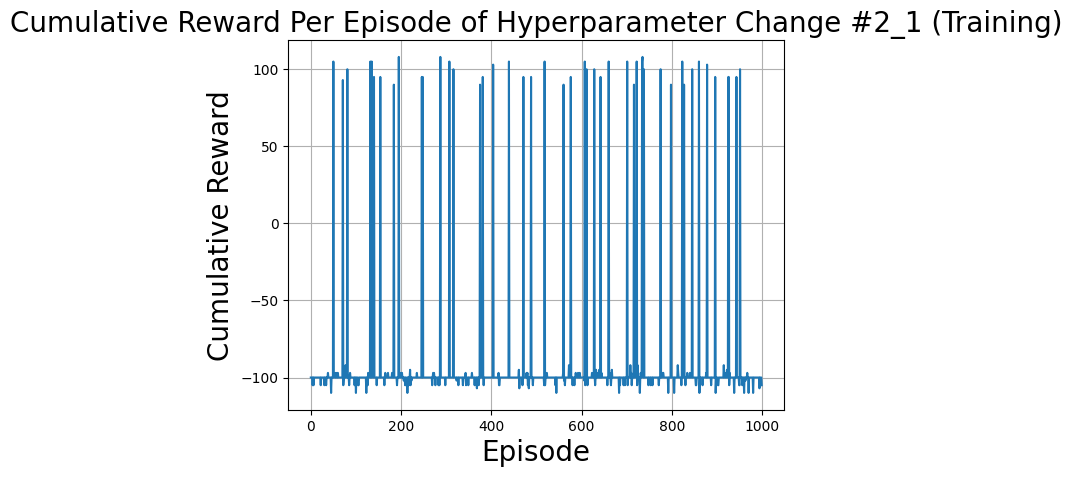

In [16]:
#Step 2) b.
plt.figure()
plt.plot(final_rewards_2_1)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode of Hyperparameter Change #2_1 (Training)', fontsize=20)
plt.grid()
plt.show()

[1.0, 0.999901004949835, 0.9998020197986801, 0.9997030445455454, 0.999604079189441, 0.9995051237293776, 0.9994061781643654, 0.9993072424934148, 0.9992083167155369, 0.9991094008297421, 0.9990104948350412, 0.9989115987304453, 0.9988127125149655, 0.9987138361876128, 0.9986149697473984, 0.9985161131933338, 0.9984172665244303, 0.9983184297396994, 0.9982196028381529, 0.9981207858188024, 0.9980219786806598, 0.9979231814227368, 0.9978243940440459, 0.9977256165435988, 0.997626848920408, 0.9975280911734855, 0.9974293433018441, 0.997330605304496, 0.997231877180454, 0.9971331589287308, 0.9970344505483393, 0.9969357520382922, 0.9968370633976026, 0.9967383846252836, 0.9966397157203487, 0.9965410566818107, 0.9964424075086834, 0.9963437681999802, 0.9962451387547147, 0.9961465191719006, 0.9960479094505515, 0.9959493095896816, 0.995850719588305, 0.9957521394454355, 0.9956535691600873, 0.9955550087312749, 0.9954564581580125, 0.9953579174393148, 0.9952593865741962, 0.9951608655616715, 0.9950623544007555, 

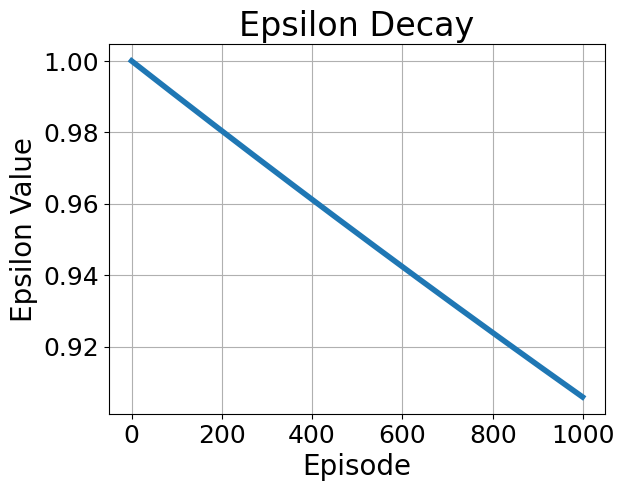

In [15]:
#Step 2) c.

print(epsilon_values_2_1)

plt.figure()
plt.plot(epsilon_values_2_1, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.ylim(ymin=0, ymax=1)
# plt.xlim(xmin=0, xmax=500)
plt.grid()
plt.show()